<a href="https://colab.research.google.com/github/mshitie/MS_KD/blob/main/batch_training/Teacher%26Student_Batch_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rarfile

from google.colab import drive
import rarfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the .rar file in Google Drive
rar_path = '/content/drive/MyDrive/computer_vision/main_data_croped.rar'

# Destination folder to extract the contents
destination_folder = '/content'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Extract the .rar file
with rarfile.RarFile(rar_path, 'r') as rar_ref:
    rar_ref.extractall(destination_folder)

print("Extraction completed.")

Mounted at /content/drive
Extraction completed.


In [ ]:
import os
import csv
import shutil

def partition_images(directory, csv_file, output_folder):
    image_files = []
    folder_counts = {}  # Dictionary to store the count of images moved to each folder

    # Read the CSV file
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        header = next(reader, None)  # Skip the header row if it exists

        # Iterate over the rows in the CSV file
        for row in reader:
            image_file = row[0]  # Assuming the image file names are in the first column
            label = row[1]  # Assuming the labels are in the second column
            image_files.append((image_file, label))

    # Create directories for each label
    labels = set(label for _, label in image_files)
    for label in labels:
        label_dir = os.path.join(output_folder, label)
        os.makedirs(label_dir, exist_ok=True)
        folder_counts[label] = 0  # Initialize the count to 0

    # Move the image files to separate label directories
    for image_file, label in image_files:
        source_path = os.path.join(directory, image_file + ".jpg")  # Assuming the file extension is '.jpg'
        destination_path = os.path.join(output_folder, label, image_file + ".jpg")

        if os.path.exists(source_path):
            print(f"Moving {source_path} to {destination_path}")
            shutil.move(source_path, destination_path)
            folder_counts[label] += 1  # Increment the count for the corresponding folder

        else:
            print(f"File not found: {source_path}")

    # Print the counts for each folder
    print("\nNumber of images moved in each folder:")
    for label, count in folder_counts.items():
        print(f"{label}: {count}")

# Directory path where the images and CSV file are located
directory_path = '/content/main_data_croped/'
csv_file_path = '/content/drive/MyDrive/computer_vision/tfti2.csv'
output_folder = "/content/main_data_croped2/"

# Create the output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Call the function to partition the images based on the labels
partition_images(directory_path, csv_file_path, output_folder)

In [4]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

import time
import timeit

<ipython-input-4-394d0b1b32f1>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [5]:
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

In [40]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

train_dir = '/content/main_data_croped2'

# Load train images
tf_train = []
for filename in os.listdir(os.path.join(train_dir, 'TF')):
    img = Image.open(os.path.join(train_dir, 'TF', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    tf_train.append(img_array)
tf_train = np.array(tf_train)

it_train = []
for filename in os.listdir(os.path.join(train_dir, 'TI')):
    img = Image.open(os.path.join(train_dir, 'TI', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    it_train.append(img_array)
it_train = np.array(it_train)

normal_train = []
for filename in os.listdir(os.path.join(train_dir, 'normal')):
    img = Image.open(os.path.join(train_dir, 'normal', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    normal_train.append(img_array)
normal_train = np.array(normal_train)

print('Done Loaded :)')

# Shape of our dataset
print(f'TF Train:', tf_train.shape)
print(f'TI Train:', it_train.shape)
print(f'Normal Train:', normal_train.shape)

tf_train_label = np.zeros(len(tf_train), dtype=float)
it_train_label = np.ones(len(it_train), dtype=float)
normal_train_label = np.full(len(normal_train), 2, dtype=float)

X_train = np.concatenate((tf_train, it_train, normal_train), axis=0)
Y_train = np.concatenate((tf_train_label, it_train_label, normal_train_label), axis=0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

Y_train = to_categorical(Y_train, num_classes=3)

print(f'X train shape:', X_train.shape)
print(f'Y train shape:', Y_train.shape)

# Split the data into training, validation, and testing sets
x_train, x_temp, y_train, y_temp = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=10)

print(f'x train shape:', x_train.shape)
print(f'x test shape:', x_test.shape)
print(f'x val shape:', x_val.shape)
print(f'y train shape:', y_train.shape)
print(f'y test shape:', y_test.shape)
print(f'y val shape:', y_val.shape)

Done Loaded :)
TF Train: (365, 224, 224, 3)
TI Train: (110, 224, 224, 3)
Normal Train: (1019, 224, 224, 3)
X train shape: (1494, 224, 224, 3)
Y train shape: (1494, 3)
x train shape: (1195, 224, 224, 3)
x test shape: (150, 224, 224, 3)
x val shape: (149, 224, 224, 3)
y train shape: (1195, 3)
y test shape: (150, 3)
y val shape: (149, 3)


In [41]:
# Teacher model with ResNet50
def build_model(backbone , lr = 1e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(3 , activation='softmax'))

  model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

  return model

resnet = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224 , 224 , 3)
)
# call the model
model = build_model(resnet , lr = 1e-4)
model.build((None, 224, 224, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23602051 (90.03 MB)
Trainable params: 23

In [42]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,verbose=1,factor=0.2, min_lr=1e-4)
filepath="ResNet50weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [43]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
# Configuration
import time
epochs = 10
batch_size = 32

# Calculate the starting time
start_time = time.time()

teacher_his = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_val, y_val),
            callbacks=[learn_control, checkpoint])


end_time = time.time()
print("--- Time taken to train : %s seconds ---" % ((end_time - start_time)))

Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 1.1199 - accuracy: 0.5967

38/38 [==============================] - 55s 420ms/step - loss: 1.1199 - accuracy: 0.5967 - val_loss: 0.6929 - val_accuracy: 0.7315 - lr: 1.0000e-04
Epoch 2/10
38/38 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8728

38/38 [==============================] - 12s 312ms/step - loss: 0.3952 - accuracy: 0.8728 - val_loss: 1.1356 - val_accuracy: 0.7047 - lr: 1.0000e-04
Epoch 3/10
38/38 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9456

38/38 [==============================] - 12s 314ms/step - loss: 0.1677 - accuracy: 0.9456 - val_loss: 1.6187 - val_accuracy: 0.6510 - lr: 1.0000e-04
Epoch 4/10
38/38 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9724

38/38 [==============================] - 12s 318ms/step - loss: 0.0985 - accuracy: 0.9724 - val_loss: 1.0577 - val_accuracy: 0.7584 - lr: 1.0000e-04
Epoch 5/10
38/38 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9866

38/38 [==============================] - 12s 315ms/step - loss: 0.0601 - accuracy: 0.9866 - val_loss: 0.9917 - val_accuracy: 0.7785 - lr: 1.0000e-04
Epoch 6/10
38/38 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9858

38/38 [==============================] - 12s 308ms/step - loss: 0.0420 - accuracy: 0.9858 - val_loss: 0.6172 - val_accuracy: 0.8054 - lr: 1.0000e-04
Epoch 7/10
38/38 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9900

38/38 [==============================] - 12s 309ms/step - loss: 0.0403 - accuracy: 0.9900 - val_loss: 0.7865 - val_accuracy: 0.8121 - lr: 1.0000e-04
Epoch 8/10
38/38 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9900

38/38 [==============================] - 12s 309ms/step - loss: 0.0404 - accuracy: 0.9900 - val_loss: 1.2956 - val_accuracy: 0.7651 - lr: 1.0000e-04
Epoch 9/10
38/38 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9849

38/38 [==============================] - 12s 311ms/step - loss: 0.0486 - accuracy: 0.9849 - val_loss: 0.8531 - val_accuracy: 0.7987 - lr: 1.0000e-04
Epoch 10/10
38/38 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9900

38/38 [==============================] - 12s 316ms/step - loss: 0.0486 - accuracy: 0.9900 - val_loss: 1.0638 - val_accuracy: 0.8054 - lr: 1.0000e-04
--- Time taken to train : 217.2554633617401 seconds ---


In [44]:
model.save_weights("ResNet50_model.h5") #using h5 extension
print("model saved!!!")

model saved!!!


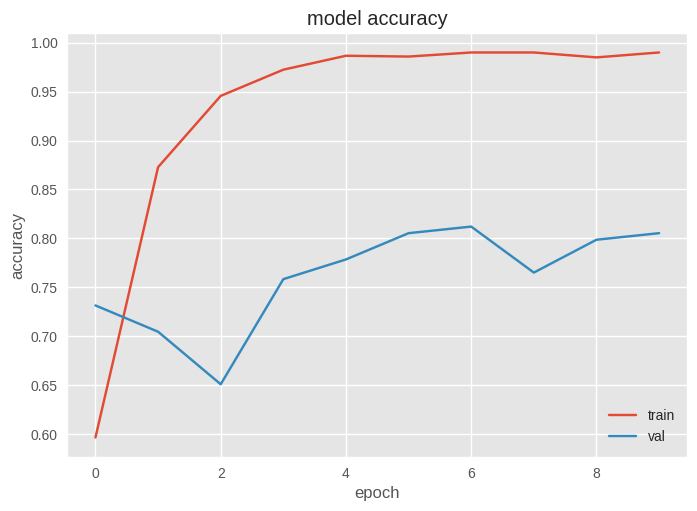

In [45]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

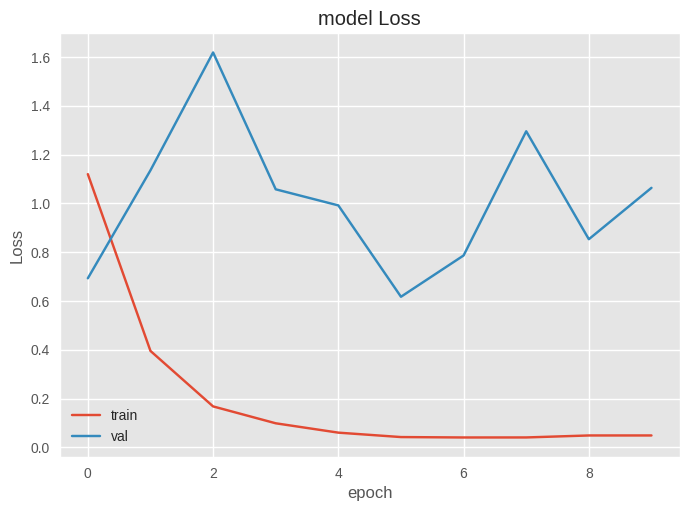

In [46]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [47]:
Y_val_pred = model.predict(x_val)
print(f'The Teacher model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

5/5 [==============================] - 2s 101ms/step
The Teacher model Accuracy on the Validation Set: 0.8053691275167785


In [48]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,y_test)

My Y_test values are:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 

In [49]:
#Now let's check my predcited values from X_test dataset
# And calculate the y_pred with time
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = model.predict(x_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

5/5 [==============================] - 0s 99ms/step
My predicted Y_test values are:
 [[1.24889310e-04 1.70237455e-03 9.98172760e-01]
 [9.99986053e-01 1.39101940e-05 2.30261909e-14]
 [3.85947764e-01 1.02160601e-02 6.03836179e-01]
 [4.02804375e-01 6.05830457e-03 5.91137350e-01]
 [9.98607457e-01 1.37912261e-03 1.34922475e-05]
 [1.58758223e-01 1.82662189e-01 6.58579648e-01]
 [4.08607477e-04 1.02281729e-02 9.89363253e-01]
 [9.56929216e-05 6.66230358e-03 9.93241966e-01]
 [6.21095598e-02 9.36501682e-01 1.38874748e-03]
 [1.82008476e-03 2.29649851e-03 9.95883405e-01]
 [3.42933506e-01 6.34797990e-01 2.22685542e-02]
 [7.77336240e-01 1.90907925e-01 3.17557752e-02]
 [9.99557793e-01 4.37767711e-04 4.44134912e-06]
 [4.34083922e-05 3.64776497e-05 9.99920130e-01]
 [2.18432350e-03 1.95397660e-02 9.78275895e-01]
 [4.18275833e-01 5.48210740e-01 3.35134752e-02]
 [3.39349463e-05 3.28686810e-03 9.96679187e-01]
 [2.08716374e-03 9.97912347e-01 4.94513756e-07]
 [1.41743582e-03 4.61027957e-03 9.93972242e-01]
 [9

In [50]:
start = timeit.default_timer()
#Your statements here

#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Teacher model with ResNet50 on the Test set is:',accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My accuracy on Teacher model with ResNet50 on the Test set is: 0.8266666666666667

Time:  0.002170773999978337 sec


In [51]:
# Classification_report
print(f'Classification Report of Resnet50:\n',classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67        35
           1       0.62      0.57      0.59        14
           2       0.86      0.95      0.90       101

    accuracy                           0.83       150
   macro avg       0.76      0.70      0.72       150
weighted avg       0.82      0.83      0.82       150



**AUC ROC**

Auc Curve on Validation:



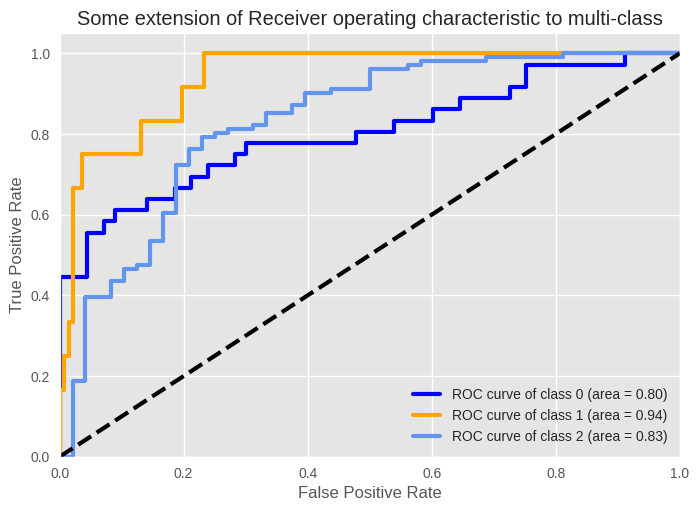

In [52]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], Y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), Y_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



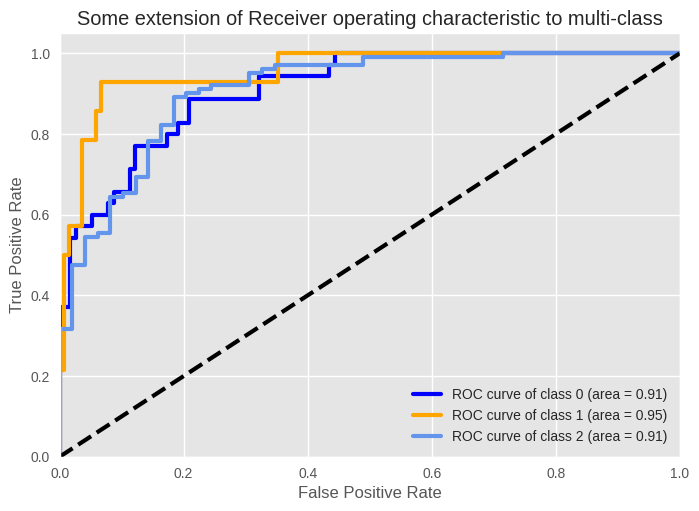

In [54]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

**Student Model**

In [55]:
# Define the student model
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model
# Hyperparameters
input_shape = (224, 224, 3) # Input shape of each image
nb_classes = 3

customstudent = Sequential()
customstudent.add(Conv2D(128, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(64, (3, 3), activation='relu'))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(32, (3, 3), activation='relu'))
customstudent.add(Dropout(0.25)) # For reguralization

customstudent.add(layers.Flatten())

customstudent.add(layers.Dense(nb_classes))
customstudent.add(layers.Activation('softmax')) # Note that we add a normal softmax layer to begin with


customstudent.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

print(customstudent.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 32)        18464     
                                                                 
 dropout_3 (Dropout)         (None, 52, 52, 32)       

In [57]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets

# Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense_2').output)

In [58]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

In [59]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val)

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

5/5 [==============================] - 0s 99ms/step
(1195, 3)
(149, 3)
(1195, 6)
(149, 6)


In [60]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
temp = 10
customstudent.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = customstudent.layers[-1].output
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model
customstudent = Model(customstudent.input, output)

customstudent.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_3_input (InputLayer  [(None, 224, 224, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 conv2d_3 (Conv2D)           (None, 222, 222, 128)        3584      ['conv2d_3_input[0][0]']      
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 128)        0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                            

In [61]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model.
# This uses a knowledge distillation loss function
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]

    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]

    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)

    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

customstudent.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc]
  )

In [62]:
# Train the student model
epochs = 20
batch_size = 32
customstudent_student_his = customstudent.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/20
38/38 [==============================] - 12s 292ms/step - loss: 0.1305 - acc: 0.2402 - val_loss: 0.0939 - val_acc: 0.6779
Epoch 2/20
38/38 [==============================] - 9s 243ms/step - loss: 0.0905 - acc: 0.6536 - val_loss: 0.0940 - val_acc: 0.6779
Epoch 3/20
38/38 [==============================] - 9s 244ms/step - loss: 0.0883 - acc: 0.6762 - val_loss: 0.0940 - val_acc: 0.6779
Epoch 4/20
38/38 [==============================] - 9s 249ms/step - loss: 0.0879 - acc: 0.6812 - val_loss: 0.0940 - val_acc: 0.6779
Epoch 5/20
38/38 [==============================] - 9s 244ms/step - loss: 0.0878 - acc: 0.6820 - val_loss: 0.0940 - val_acc: 0.6779
Epoch 6/20
38/38 [==============================] - 9s 243ms/step - loss: 0.0878 - acc: 0.6812 - val_loss: 0.0940 - val_acc: 0.6779
Epoch 7/20
38/38 [==============================] - 9s 244ms/step - loss: 0.0879 - acc: 0.6812 - val_loss: 0.0940 - val_acc: 0.6779
Epoch 8/20
38/38 [==============================] - 9s 244ms/step - loss: 0

<ipython-input-63-4dfd3e4fd4f9>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


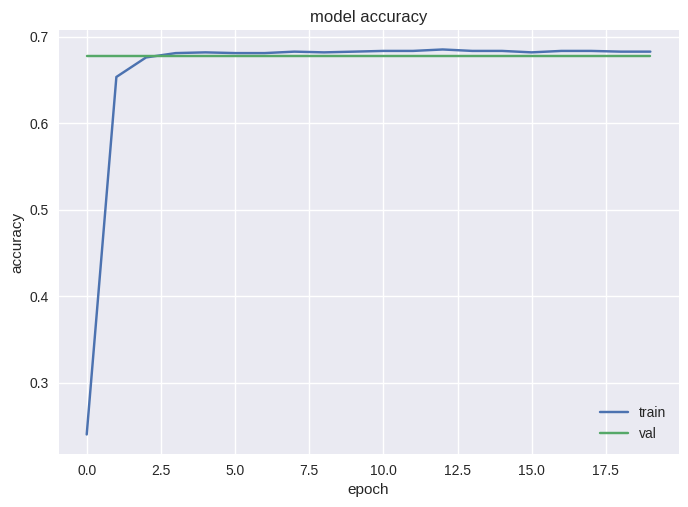

In [63]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.style.use('seaborn')
plt.plot(customstudent_student_his.history['acc'])
plt.plot(customstudent_student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

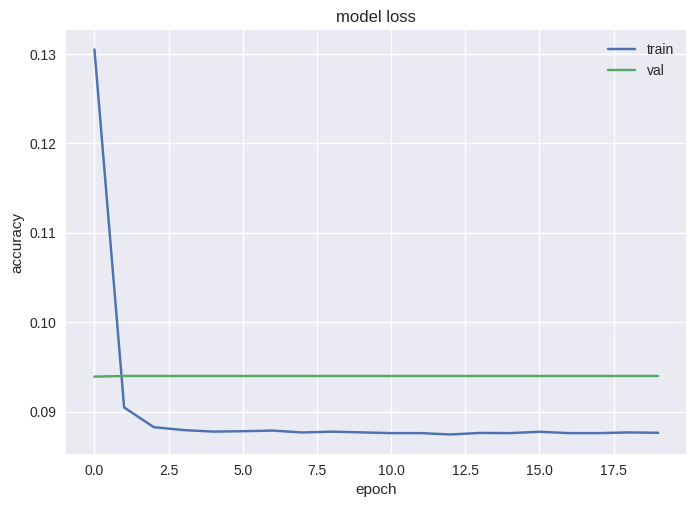

In [64]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(customstudent_student_his.history['loss'])
plt.plot(customstudent_student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [65]:
Y_val_pred_student = customstudent.predict(x_val)
print(f'The CustomStudent model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred_student, axis=1)))

5/5 [==============================] - 0s 31ms/step
The CustomStudent model Accuracy on the Validation Set: 0.6778523489932886


In [66]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,y_test)

My Y_test values are:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 

In [67]:
#Now let's check my predcited values from X_test dataset
import timeit

start = timeit.default_timer()
#Your statements here
y_pred_student = customstudent.predict(x_test)
print(f'My predicted Y_test values are:\n' ,y_pred_student)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

5/5 [==============================] - 0s 31ms/step
My predicted Y_test values are:
 [[0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.211

In [68]:
start = timeit.default_timer()
#Your statements here

#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Custom Student model on the Test set is:',accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_student, axis=1)))

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My accuracy on Custom Student model on the Test set is: 0.6733333333333333

Time:  0.002849432000402885 sec


In [69]:
# Classification_report
print(f'Classification Report of Resnet50:\n',classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_student, axis=1)))

Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.00      0.00      0.00        14
           2       0.67      1.00      0.80       101

    accuracy                           0.67       150
   macro avg       0.22      0.33      0.27       150
weighted avg       0.45      0.67      0.54       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Auc Curve on Validation:



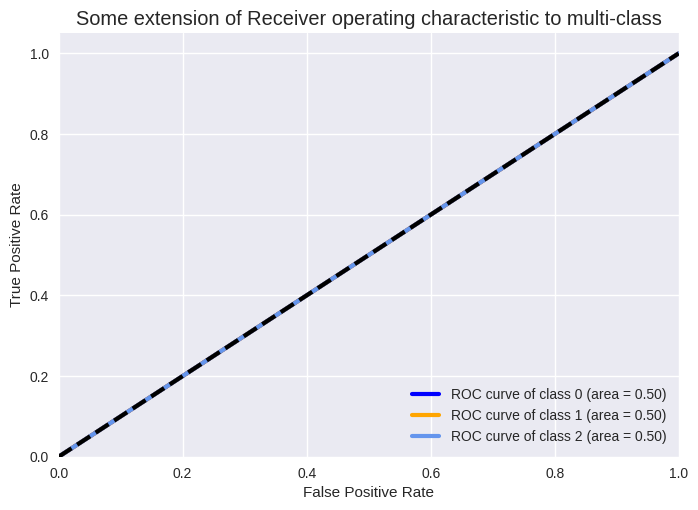

In [70]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_new[:, i], Y_val_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_new.ravel(), Y_val_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



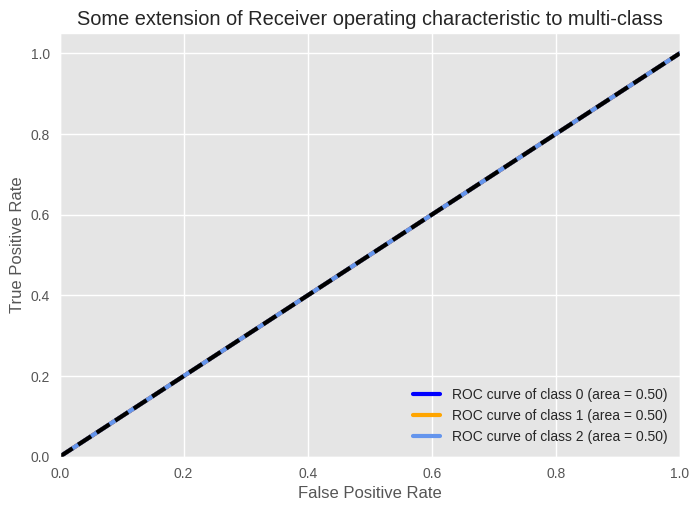

In [71]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

-----